## Capstone project: A different way to select input data for the xLS algorithms
Welcome to the capstone project! To complete this assignment, follow the instructions below. When you have completed your modifications to the sample code that I have provided as a starting point, click on the <b>"Submit Assignment"</b> button to submit your code to the grader.

### How to use this Jupyter notebook to achieve project objectives
This Jupyter notebook operates in the same way as all of the other Jupyter notebooks that you have used so far in this specialization. You can type Octave code into notebook cells and execute that code to see how it functions. This allows you to test your code fully before submitting it for grading.

Only one notebook cell is actually graded – the one marked with <code>"% GRADED FUNCTION"</code> in its first line. Do not modify that line – otherwise the grader will not be able to find the correct function for grading.
When you are satisfied that you have achieved the project's objectives, click on the "<b>Submit Assignment</b>" button, above.

### Concept behind the project
You have now learned several different total-capacity estimation methods. Some of these methods work better than others in general, but any method is only as good as the data you give it to work with. In this project, you will explore a different way to determine the "x" and "y" data you use as input to the total-capacity estimation methods.

In the fourth week of the course, I shared with you some simulation examples representing HEV and BEV scenarios. In the HEV scenarios, we accumulated data over a fixed duration of time for each (x,y) data pair used to update the total-capacity estimates (e.g., we updated once every 300 seconds, exactly). In two of the BEV scenarios, we instead accumulated (x,y) data pairs over random-length periods of time during which the battery pack was being charged via a plug-in charging mechanism. The first method is simple to apply, but does not tend to give uncertainty bounds that are as tight as given by the second method. But, not all applications have periods of controlled operation, such as plug-in charging, so not all applications can use the second approach.

Here, you will look at a third approach. In this third approach, one (x,y) data pair is created every time the cell state-of-charge has changed by at least some threshold amount since the last update. You learned in lesson 4.1.7 that a large threshold will maximize the value of the "x" information for an update to the estimate of total capacity. However, if the threshold is too large (e.g., 90%), you will never update the total-capacity estimates because the state-of-charge may never change by that amount during normal operation. Also, if the threshold is too large, the "y" data will accumulate current-sensor measurement errors over a long time, and will have high uncertainty regarding the correct value.

So: large threshold tends to provide higher-quality "x" data to the updates but noisier "y" data; small threshold tends to cause more frequent updates, which is needed to track a moving total capacity and to adapt if the initial estimate is badly wrong.

In this project, you will experiment with this threshold "dz" as well as with the forgetting-factor "gamma" for the WTLS, TLS, and AWTLS methods. You will be graded based on the root-mean-squared error between the true capacity and estimated capacity using your set of tuning parameters (dz,gamma) ... the lower the error the better.

Your deliverable will be a set of (dz,gamma) tuning pairs for the WTLS, TLS, and AWTLS methods, in the <code>tunexLS</code> function, below.

## Background to the data provided to you for this project
The remainder of this notebook implements the basic framework for the project. The majority of the coding has already been done for you, so this background description is for your information only.

The raw dataset was created as follows. First, the battery pack was "fully charged" to a top state of charge of 95%. Then, a random number of urban dynamometer driving schedule (UDDS) profiles were simulated, having the effect of discharging the cell to a ramdom point. Then, the battery pack was charged in a constant-power mode. This discharging/charging protocol was repeated 200 times (simulating roughly 1 year of vehicle operation). The cell's capacity slowly decayed over this year of operation.

This simulation was performed with a full ESC cell model: one you learned about in the second course in this specialization. The output of the simulation was true cell state-of-charge versus time as well as cell current versus time. Measurement noise was then added to the SOC measurements (1% standard deviation), and to the current-sensor measurements (assuming a 12-bit A2D).

The following notebook cell plots a small portion at the beginning of the simulation of state-of-charge versus time (both noisy and noise-free values). You can see the discharge/charge cycles quite clearly. You can also zoom into the plot to see more detail.

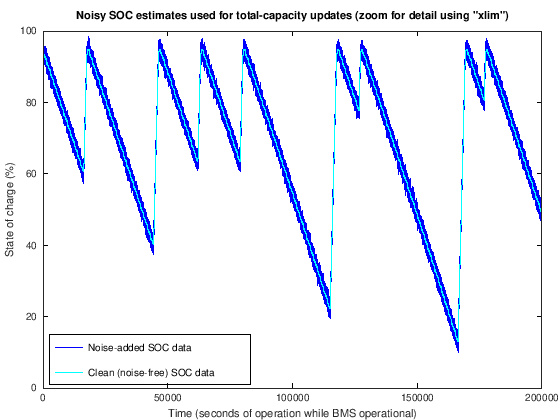

In [1]:
% Plot the clean and noisy SOC used by this project
load readonly/shortDataset.mat
plot(0:199999,100*noisyData,'b'); hold on; plot(0:199999,100*cleanData,'c','linewidth',2);
xlabel('Time (seconds of operation while BMS operational)');
ylabel('State of charge (%)');
title('Noisy SOC estimates used for total-capacity updates (zoom for detail using "xlim")')
legend('Noise-added SOC data','Clean (noise-free) SOC data','location','southwest')
% for example, uncomment the next line to show more detail
% xlim([0 20000])

The following notebook cell plots the true capacity as it changes over time for the overall simulation. This general "shape" of capacity fade is common in lithium-ion cells. Also, 2.5% capacity loss in the first year is not unusual.

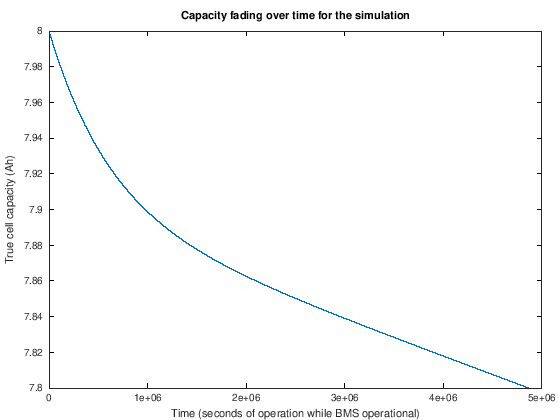

In [2]:
% Plot the true capacity versus time
load readonly/Qtrue.mat
plot(Qtrue);
xlabel('Time (seconds of operation while BMS operational)');
ylabel('True cell capacity (Ah)');
title('Capacity fading over time for the simulation');

The output of the vehicle simulation comprizes nearly 5 million samples of noisy SOC and a corresponding 5 million samples of noisy electrical current. If we choose a threshold of dz = 0.05, we need to search through the entire 5 million samples to see every time the cell SOC changes by at least 5% from the last time we made a total-capacity update. This is a straightforward but time-consuming process, so I have already done it for you. For your reference, the function that I used to do so is: <b>(You do not need to run this code yourself!)</b>

In [3]:
% Determine vectors of total-capacity updates (x,y) with corresponding variances.
% zhatk - roughly 5 million values of noisy SOC versus time
% etiak - roughly 5 million values of noisy coulombic efficiency times measured current
% dz - threshold value in SOC that must be exceeded before we create a new output data pair
% SigmaZ - variance of each SOC measurement error
% Sigmai - variance of each current-sensor measurement error
%
% xi - vector of change in SOC, one value for every total-capacity update
% yi - vector of accumulated ampere-seconds over that interval for every update
% SigmaXi - vector of uncertainty in change in SOC
% SigmaYi - vector of uncertainty in accumulated current
% k - vector of absolute time of beginning of interval used in measurement update
function [xi,yi,SigmaXi,SigmaYi,k] = processData(zhatk,etaik,dz,SigmaZ,Sigmai)
  xi = []; yi = []; SigmaXi = []; SigmaYi = []; k = [];
  ind1 = 1;
  while 1,
    % find next time absolute change in SOC is greater than dz (note: ind2 >= 2)
    ind2 = find(abs(zhatk(ind1:end) - zhatk(ind1)) > dz,1,'first');
    % Next two lines force xi to be somewhat random in the neighborhood of absolute change of dz 
    % Otherwise, xi are biased! (i.e. abs(xi)>dz always, so noise is
    % one-sided and math for xLS breaks down)
    ind2 = ind2 + randi(10); if ind1+ind2-1>length(zhatk), ind2 = length(zhatk) - ind1 + 1; end
    if isempty(ind2), break; end % no more changes greater than dz, so return to calling function
    xi = [xi; zhatk(ind1) - zhatk(ind1+ind2-1)];  % add this "x" value to xi
    yi = [yi; sum(etaik(ind1:ind1+ind2-2))/3600]; % add this "y" value to yi
    SigmaXi = [SigmaXi; 2*SigmaZ];                % add 2*variance of one SOC estimate
    SigmaYi = [SigmaYi; (ind2-1)*Sigmai];         % add accumulated current-sensor variance
    k = [k; ind1];                                % add absolute time of start of interval
    ind1 = ind1+ind2;                             % move starting time for next interval
  end
end

I have run this code for you already for thresholds <code>dz = 0.05:0.01:0.50</code>, and have stored the data in <code>Qdata.mat</code>. This file stores a struct array <code>Qdata</code> of size 1x50 (first four elements are empty; remaining elements are for each value of dz*100, respectively). Each element of this array is a structure having fields:
* xi - vector of "x" values from (x,y) pairs for total-capacity updates
* yi - vector of "y" values from (x,y) pairs for total-capacity updates
* SigmaXi - vector of variances on each xi
* SigmaYi - vector of variances on each yi
* k - vector of absolute time for beginning of each interval

That is, the data are of the same format output from <code>processData.m</code>, above. 

To use these data in a simulation of your own to evaluate different tuning factors, you will first need to read it from storage:

In [4]:
addpath readonly % make sure xLSalgos.m is in the path
load readonly/Qdata.mat % load the pre-processed {xi, yi, SigmaXi, SigmaYi, k} data

Next, you will need a function that executes the xLS algorithms for some specific tuning factors, computes root-mean-squared total-capacity estimation error for that set of tuning factors, and plots some results. The following function will do this for you:

In [5]:
% Evaluate xLS algorithms for a set of tuning factors, compute RMS errors, plot results
% dz - index of threshold to use. For example, for threshold of 0.15 use dz = 15
% gamma - forgetting factor, <= 1.0
% method - xLS method number = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS
% Qdata - compiled dataset of (xi,yi) etc. loaded from Qdata.mat
% Qtrue - true capacity, loaded from Qtrue.mat
%
% rmsErr - root-mean-squared total-capacity estimation error for this tuning set
function rmsErr = computeResults(dz,gamma,method,Qdata,Qtrue)
  % compute capacity estimates for this dataset, using exact initialization
  [Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
  dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
  Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
  Qerr = Qtrue - Qest';
  rmsErr = sqrt(mean(Qerr.^2));

  % Plot results with 3-sigma bounds
  hold on; % use "stairs" to extend estimates until next update automatically
  stairs([Qdata(dz).k; dataLen],[Qhat(:,method); Qhat(end,method)],'b','linewidth',3); % WLS
  % Plot true capacity
  plot(1:dataLen,Qtrue,'k-','linewidth',1);
  % Plot bounds
  stairs([Qdata(dz).k; dataLen],[Qhat(:,method)+3*sqrt(SigmaQ(:,method)); ...
                                 Qhat(end,method)+3*sqrt(SigmaQ(end,method))],'b--','linewidth',0.5);
  stairs([Qdata(dz).k; dataLen],[Qhat(:,method)-3*sqrt(SigmaQ(:,method)); ...
                                 Qhat(end,method)-3*sqrt(SigmaQ(end,method))],'b--','linewidth',0.5);
  
  switch method,
    case 1, title('Capacity estimates, bounds: WLS'); 
    case 2, title('Capacity estimates, bounds: WTLS'); 
    case 3, title('Capacity estimates, bounds: TLS'); 
    case 4, title('Capacity estimates, bounds: AWTLS'); 
  end
  xlabel('Data sample number'); ylabel('Capacity estimate (Ah)');
  legend('Capacity estimate','True capacity','Confidence bounds on estimate')
end  

The following short code segment is an example of how you might invoke this function to compute RMS error and visualize results.

In [6]:
# Goal 0.033

In [7]:
dz = 48;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.94; % look at xLS performance for forgetting factor gamma = 1.0
method = 2;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.032556


In [35]:
dz = 48;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.90; % look at xLS performance for forgetting factor gamma = 1.0
method = 3;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.044573


In [41]:
dz = 47;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.92; % look at xLS performance for forgetting factor gamma = 1.0
method = 3;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.031576


In [8]:
dz = 32;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.9921; % look at xLS performance for forgetting factor gamma = 1.0
method = 2;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.039045


In [9]:
dz = 43;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.9929; % look at xLS performance for forgetting factor gamma = 1.0
method = 2;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.034593


In [10]:
dz = 25;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.99; % look at xLS performance for forgetting factor gamma = 1.0
method = 3;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.049695


In [11]:
dz = 38;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.99; % look at xLS performance for forgetting factor gamma = 1.0
method = 3;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.046762


In [12]:
dz = 30;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.99; % look at xLS performance for forgetting factor gamma = 1.0
method = 3;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.080538


In [13]:
dz = 29;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.99; % look at xLS performance for forgetting factor gamma = 1.0
method = 3;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.093874


In [14]:
dz = 43;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.98; % look at xLS performance for forgetting factor gamma = 1.0
method = 4;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.036659


In [15]:
dz = 48;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.96; % look at xLS performance for forgetting factor gamma = 1.0
method = 4;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.032785


In [16]:
dz = 48;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.94; % look at xLS performance for forgetting factor gamma = 1.0
method = 4;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.032553


In [47]:
dz = 48;     % look at xLS performance for threshold = dz/100 = 0.15
gamma = 0.94; % look at xLS performance for forgetting factor gamma = 1.0
method = 2;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS

[Qhat,SigmaQ]=xLSalgos(Qdata(dz).xi,Qdata(dz).yi,Qdata(dz).SigmaXi,Qdata(dz).SigmaYi,gamma,8,1e-2);
dataLen = length(Qtrue); % used later on -- number of samples in simulation, nearly 5 million

  % First, note that Qhat updates only every time Qdata(dz).k changes -- it stays constant between xLS updates
  % So, we need to replicate Qhat estimates from one value of "k" until the next.
Qest = repelems(Qhat(:,method),[1:length(Qdata(dz).k);diff([Qdata(dz).k; length(Qtrue)+1])']);
Qerr = Qtrue - Qest';
rmsErr2 = sqrt(mean(Qerr.^2))

rmsErr2 =  0.032556


In [17]:
#dz = 38;     % look at xLS performance for threshold = dz/100 = 0.15
#gamma = 0.99; % look at xLS performance for forgetting factor gamma = 1.0
#method = 3;  % method = 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS
#rmsErr = computeResults(dz,gamma,method,Qdata,Qtrue)
#ylim([7 9])

## Your assignment
Each xLS method will give different performance for different tuning sets (dz,gamma). Your task for this project is to determine the best set of tuning factors that you can find for the WTLS, TLS, and AWTLS methods. A grading rubric is given under the project description, so that you can know how well you are doing before you submit your assignment for grading.

You will need to modify the "dz" and "gamma" variables for methods 2, 3, and 4, below. Do not change anything else in this notebook cell.

In [42]:
% GRADED FUNCTION (do not modify this line)

% function [dz, gamma] = tunexLS(method)
%
% method - the method to tune: 1 for WLS, 2 for WTLS, 3 for TLS, 4 for AWTLS
%
% dz - your tuning value for "best" difference in SOC threshold for each xLS algorithm
% gamma - your tuning value for "best" forgetting factor for each xLS algorithm

function [dz, gamma] = tunexLS(method)

  % BEGIN MODIFYING CODE AFTER THIS
  switch(method)
    case 1, % for the WLS method ... you are not required to tune these values
      dz = 15;      % A sample value... you are not required to change it
      gamma = 1.0;  % A sample value... you are not required to change it
    case 2, % for the WTLS method ... you are required to tune these values
      dz = 48;      % This is a sample value. You will need to change it.
      gamma = 0.94;  % This is a sample value. You will need to change it.
    case 3, % for the TLS method ... you are required to tune these values
      dz = 47;      % This is a sample value. You will need to change it.
      gamma = 0.92;  % This is a sample value. You will need to change it.
    case 4, % for the AWTLS method ... you are required to tune these values
      dz = 48;      % This is a sample value. You will need to change it.
      gamma = 0.94;  % This is a sample value. You will need to change it.
  end
end  

To test your tuning, you might use a code segment like this:

rmsErr =  0.031576
Assuming that your 3-sigma bounds are okay, you would receive a grade of 10 for this method.


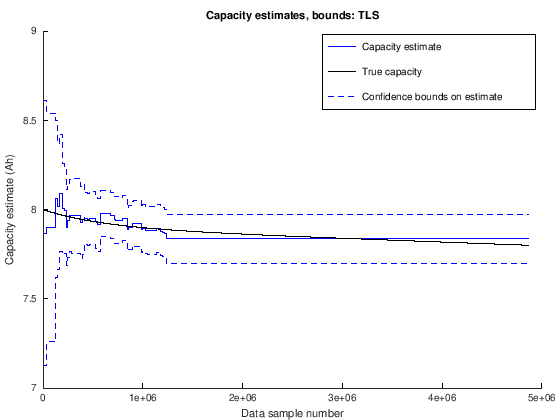

In [43]:
method = 3; % for example... but change this to test different methods
[dz,gamma] = tunexLS(method);
rmsErr = computeResults(dz,gamma,method,Qdata,Qtrue)

% compute estimate of grade for this tuning...
gradingTable = [...
    0.00    0.0600    0.0790    0.0600
    0.00    0.0570    0.0760    0.0570
    0.00    0.0550    0.0720    0.0550
    0.00    0.0520    0.0700    0.0520
    0.00    0.0510    0.0670    0.0510
    0.00    0.0490    0.0610    0.0490
    0.00    0.0470    0.0570    0.0470
    0.00    0.0410    0.0510    0.0410
    0.00    0.0360    0.0460    0.0360
    0.00    0.0330    0.0330    0.0330];
grade = find(rmsErr < gradingTable(:,method),1,'last');
if isempty(grade), grade = 0; end
fprintf('Assuming that your 3-sigma bounds are okay, you would receive a grade of %d for this method.\n',grade)


When you are satisfied with your tuning, click on the "<b>Submit Assignment</b>" button, above.

The assignment will be graded out of a maximum of 30 points possible (10 points for your WTLS result, 10 points for your TLS result, and 10 points for your AWTLS result). For every method:
* If your code produces errors when executed, the grade is zero
* If your total-capacity estimation error is ever outside the 3-sigma bounds, the grade is zero
* Otherwise, your grade can be found looking up the root-mean-squared total-capacity estimation error in the grading table given in the project description page (the sample code above performs this computation for you)
